In [208]:
from SDP_interaction_inference.simulation import gillespie_birth_death, gillespie_telegraph
import numpy as np
from copy import copy
import math
from scipy.special import stirling2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [248]:
rng = np.random.default_rng(231)

In [29]:
def compute_order(alpha):
    '''Sum of elements of a power.'''
    order = 0
    for alpha_i in alpha:
        order += alpha_i
    return order

def compute_Nd(S, d):
    '''Number of moments of order <= d (S species)'''
    Nd = math.factorial(S + d) // (math.factorial(d) * math.factorial(S))
    return Nd

def compute_powers(S, d):
    '''Compute the Nd powers of order <= d (S species)'''

    # all powers
    powers = [[0 for s in range(S)]]

    # powers of order d = 0
    powers_prev = [[0 for s in range(S)]]

    # for order d = 1, ..., d
    for order in range(1, d + 1):

        # store powers of order d
        powers_current = []

        # for each power of order d - 1
        for alpha in powers_prev:

            # for each index
            for i in range(S):

                # add 1 to power at index
                alpha_new = copy(alpha)
                alpha_new[i] += 1

                # store (avoid repeats)
                if alpha_new not in powers_current:
                    powers_current.append(alpha_new)

        # update d - 1 powers
        powers += powers_current

        # update overall powers
        powers_prev = powers_current

    return powers

def add_powers(*powers, S):
    '''Add powers (lists) of size S.'''
    plus = [0 for i in range(S)]
    for i in range(S):
        for power in powers:
            plus[i] += power[i]
    return plus

def falling_factorial(n, k):
    '''FF(n,k) = n(n-1) ... (n - k + 1).'''
    val = 1
    for i in range(k):
        val *= (n - i)
    return val

def binomial_moment(n, p, l):
    '''For X ~ Bin(n, p) compute E[X^l].'''
    val = 0
    for k in range(l + 1):
        val += falling_factorial(n, k) * stirling2(l, k) * p**k
    return val

def poisson_moment(lam, l):
    '''For X ~ Poi(lam) compute E[X^l]'''
    val = 0
    for k in range(l + 1):
        val += stirling2(l, k) * lam**k
    return val

# Alternative Bootstrap Confidence Intervals

Use Percentile bootstrap intervals, investigate these and consider other methods

In [66]:
def compute_exact_moments(params, d):

    if params['k_reg'] > 0:
        raise NotImplementedError("Exact moments not available for k_reg > 0.")
    powers = compute_powers(S=2, d=d)
    Nd = compute_Nd(S=2, d=d)
    moments = np.empty(Nd)
    for i, alpha in enumerate(powers):
        E_x1 = poisson_moment(params['k_tx_1'] / params['k_deg_1'], alpha[0])
        E_x2 = poisson_moment(params['k_tx_2'] / params['k_deg_2'], alpha[1])
        moments[i] = E_x1 * E_x2

    return moments

In [59]:
def percentile_bootstrap(sample, d, resamples=None, confidence=0.95):
    '''
    Compute confidence intervals on the moments of a sample of count pairs, use
    resamples number of bootstrap resamples (default to sample size) and estimate
    moments up to order d.

    Args:
        sample: list of tuples (x1, x2) of integer counts per cell
        d: maximum moment order to estimate
        resamples: integer number of bootstrap resamples to use

    Returns:
        (2 x Nd) numpy array of CI bounds on each Nd moment of order <= d
    '''

    # get sample size
    n = len(sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n

    # helpful values
    powers = compute_powers(S=2, d=d)
    Nd = compute_Nd(S=2, d=d)

    # initialize random generator
    rng = np.random.default_rng()

    # convert string to tuple if neccessary (pandas reading csv to string)
    #if type(sample[0]) == str:
    #    sample = [literal_eval(count_pair) for count_pair in sample]

    # separate sample pairs
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # split into 2 N x n arrays
    x1_boot = boot[:, :, 0]
    x2_boot = boot[:, :, 1]

    # estimate
    moment_bounds = np.zeros((2, Nd))
    moment_estimates_total = np.zeros((resamples, Nd))
    for i, alpha in enumerate(powers):

        # raise boot to powers
        x1_boot_alpha = x1_boot**alpha[0]
        x2_boot_alpha = x2_boot**alpha[1]

        # multiply (N x n)
        boot_alpha = x1_boot_alpha * x2_boot_alpha

        # mean over sample axis (N x 1)
        moment_estimates = np.mean(boot_alpha, axis=1)
        
        # store
        moment_estimates_total[:, i] = moment_estimates

        # quantile over boot axis (2 x 1)
        alpha = 1 - confidence
        moment_interval = np.quantile(moment_estimates, [(alpha / 2), 1 - (alpha / 2)])

        # store
        moment_bounds[:, i] = moment_interval

    return moment_bounds, moment_estimates_total

In [203]:
# settings
k_tx = 2
k_deg = 1
k_reg = 0

n = 1000
N = 1000

# sample
params = {
    'k_tx_1': k_tx,
    'k_tx_2': k_tx,
    'k_deg_1': k_deg,
    'k_deg_2': k_deg,
    'k_reg': k_reg
}
sample = gillespie_birth_death(params, n)

In [217]:
# choose order
d_boot = 4

# bootstrap
percentile_bounds, percentile_estimates = percentile_bootstrap(sample, d=d_boot, resamples=1000, confidence=0.95)

# compute exact moments
exact_moments = compute_exact_moments(params, d=d_boot)

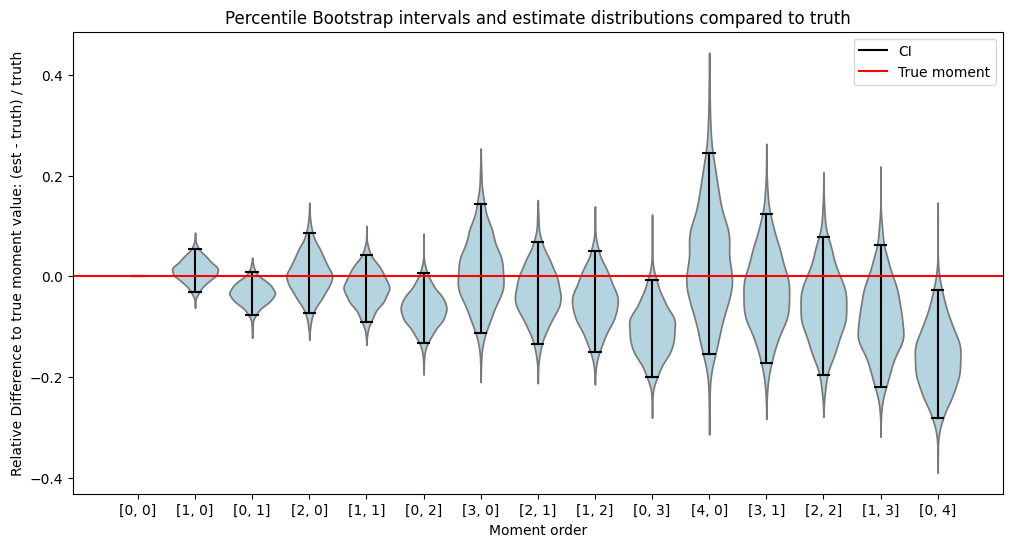

In [218]:
fig, axs = plt.subplots(figsize=(12, 6))
Nd = compute_Nd(S=2, d=d_boot)
estimates = (percentile_estimates - exact_moments) / exact_moments
sns.violinplot(estimates, inner=None, palette=["lightblue"] * Nd)
eps = 0.1
label="CI"
for i in range(Nd):
    if i > 0: label=None
    lb = (percentile_bounds[0, i] - exact_moments[i]) / exact_moments[i]
    ub = (percentile_bounds[1, i] - exact_moments[i]) / exact_moments[i]
    plt.plot([i - eps, i + eps], [lb, lb], color="black", label=label)
    plt.plot([i - eps, i + eps], [ub, ub], color="black")
    plt.plot([i, i], [lb, ub], color="black")
plt.axhline(0, color="red", label="True moment")
axs.set_xticks(range(Nd))
axs.set_xticklabels(compute_powers(S=2, d=d_boot))
plt.xlabel("Moment order")
plt.ylabel("Relative Difference to true moment value: (est - truth) / truth")
plt.title("Percentile Bootstrap intervals and estimate distributions compared to truth")
plt.legend()
plt.show()

## Notes

- Worse intervals for higher order moments
- Sometimes issues estimating powers of single species e.g. [0, 1], [0, 2], [0, 3], etc with low estimates
- Some samples produce all very good intervals, other produce mostly all bad intervals
    - dominates effects of order

## Other intervals

In [252]:
def scipy_intervals(sample, d_boot, btype):
    Nd = compute_Nd(S=2, d=d_boot)
    intervals = np.empty((2, Nd))
    powers = compute_powers(S=2, d=d_boot)
    for i, alpha in enumerate(powers):
        if i == 0:
            intervals[:, i] = [None, None]
        if alpha[0] == 0:
            def statistic(x):
                return np.mean(x**alpha[1])
            boot = scipy.stats.bootstrap(np.array([x[1] for x in sample]).reshape(1, -1), statistic, method=btype)
            intervals[0, i] = boot.confidence_interval.low
            intervals[1, i] = boot.confidence_interval.high
        elif alpha[1] == 0:
            def statistic(x):
                return np.mean(x**alpha[0])
            boot = scipy.stats.bootstrap(np.array([x[0] for x in sample]).reshape(1, -1), statistic, method=btype)
            intervals[0, i] = boot.confidence_interval.low
            intervals[1, i] = boot.confidence_interval.high
        else:
            intervals[:, i] = [None, None]
    return intervals

In [242]:
# settings
k_tx = 2
k_deg = 1
k_reg = 0

n = 1000
N = 1000

# sample
params = {
    'k_tx_1': k_tx,
    'k_tx_2': k_tx,
    'k_deg_1': k_deg,
    'k_deg_2': k_deg,
    'k_reg': k_reg
}
sample = gillespie_birth_death(params, n)

In [243]:
# choose order
d_boot = 4

# bootstrap
percentile_bounds, percentile_estimates = percentile_bootstrap(sample, d=d_boot, resamples=1000, confidence=0.95)

# compute exact moments
exact_moments = compute_exact_moments(params, d=d_boot)

In [245]:
# run bootstraps
intervals_bca = scipy_intervals(sample, "bca")
intervals_basic = scipy_intervals(sample, "basic")
intervals_percentile = scipy_intervals(sample, "percentile")

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\willi\AppData\Local\Temp\ipykernel_22556\2947491617.py:10: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  boot = scipy.stats.bootstrap(np.array([x[1] for x in sample]).reshape(1, -1), statistic, method=btype)


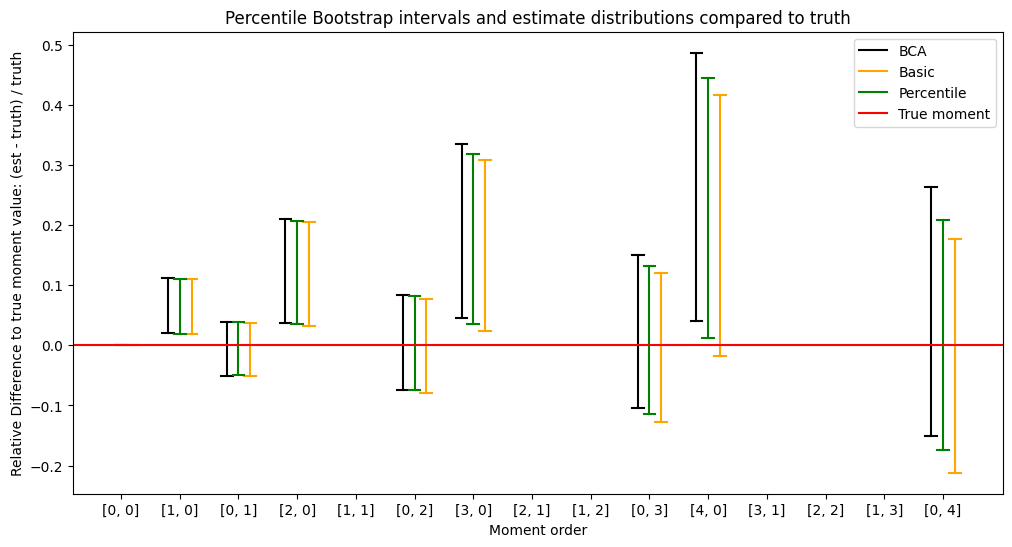

In [247]:
fig, axs = plt.subplots(figsize=(12, 6))
Nd = compute_Nd(S=2, d=d_boot)
#estimates = (percentile_estimates - exact_moments) / exact_moments
#sns.violinplot(estimates, inner=None, palette=["lightblue"] * Nd)
eps = 0.1
dt = 0.2
label_BC = "BCA"
label_B="Basic"
label_P="Percentile"
for i in range(Nd):
    if i > 0:
        label_BC = None
        label_B = None
        label_P = None
    # BCA
    lb = (intervals_bca[0, i] - exact_moments[i]) / exact_moments[i]
    ub = (intervals_bca[1, i] - exact_moments[i]) / exact_moments[i]
    plt.plot([i - eps - dt, i + eps - dt], [lb, lb], color="black", label=label_BC)
    plt.plot([i - eps - dt, i + eps - dt], [ub, ub], color="black")
    plt.plot([i - dt, i - dt], [lb, ub], color="black")
    # Basic
    lb = (intervals_basic[0, i] - exact_moments[i]) / exact_moments[i]
    ub = (intervals_basic[1, i] - exact_moments[i]) / exact_moments[i]
    plt.plot([i - eps + dt, i + eps + dt], [lb, lb], color="orange", label=label_B)
    plt.plot([i - eps + dt, i + eps + dt], [ub, ub], color="orange")
    plt.plot([i + dt, i + dt], [lb, ub], color="orange")
    # Percentile
    lb = (intervals_percentile[0, i] - exact_moments[i]) / exact_moments[i]
    ub = (intervals_percentile[1, i] - exact_moments[i]) / exact_moments[i]
    plt.plot([i - eps, i + eps], [lb, lb], color="green", label=label_P)
    plt.plot([i - eps, i + eps], [ub, ub], color="green")
    plt.plot([i, i], [lb, ub], color="green")
plt.axhline(0, color="red", label="True moment")
axs.set_xticks(range(Nd))
axs.set_xticklabels(compute_powers(S=2, d=d_boot))
plt.xlabel("Moment order")
plt.ylabel("Relative Difference to true moment value: (est - truth) / truth")
plt.title("Percentile Bootstrap intervals and estimate distributions compared to truth")
plt.legend()
plt.show()

## Unknown exact moment comparison

In [249]:
def downsample_data(sample, mean_capture):

    n = len(sample)

    b = (1 / mean_capture) - 1

    # capture efficiency
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=1000)

    # split
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # downsample
    x1_downsample = rng.binomial(x1_sample, beta).tolist()
    x2_downsample = rng.binomial(x2_sample, beta).tolist()

    # combine
    downsample = list(zip(x1_downsample, x2_downsample))

    return downsample, beta

In [250]:
# settings
k_on = 0.75
k_off = 0.75
k_tx = 5
k_deg = 1
k_reg = 0.2

n = 1000
N = 1000

# sample
params = {
    'k_on_1': k_on,
    'k_on_2': k_on,
    'k_off_1': k_off,
    'k_off_2': k_off,
    'k_tx_1': k_tx,
    'k_tx_2': k_tx,
    'k_deg_1': k_deg,
    'k_deg_2': k_deg,
    'k_reg': k_reg
}
sample = gillespie_telegraph(params, n)

In [251]:
# downsample
mean_capture = 0.5
downsample, beta = downsample_data(sample, mean_capture)

# mean expression level
print(f"Mean expression {np.mean(downsample)}")

Mean expression 0.9875


In [257]:
# choose order
d_boot = 3

# run bootstraps
intervals_bca = scipy_intervals(downsample, d_boot, "bca")
intervals_basic = scipy_intervals(downsample, d_boot, "basic")
intervals_percentile = scipy_intervals(downsample, d_boot, "percentile")

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\willi\AppData\Local\Temp\ipykernel_22556\2432251564.py:11: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  boot = scipy.stats.bootstrap(np.array([x[1] for x in sample]).reshape(1, -1), statistic, method=btype)


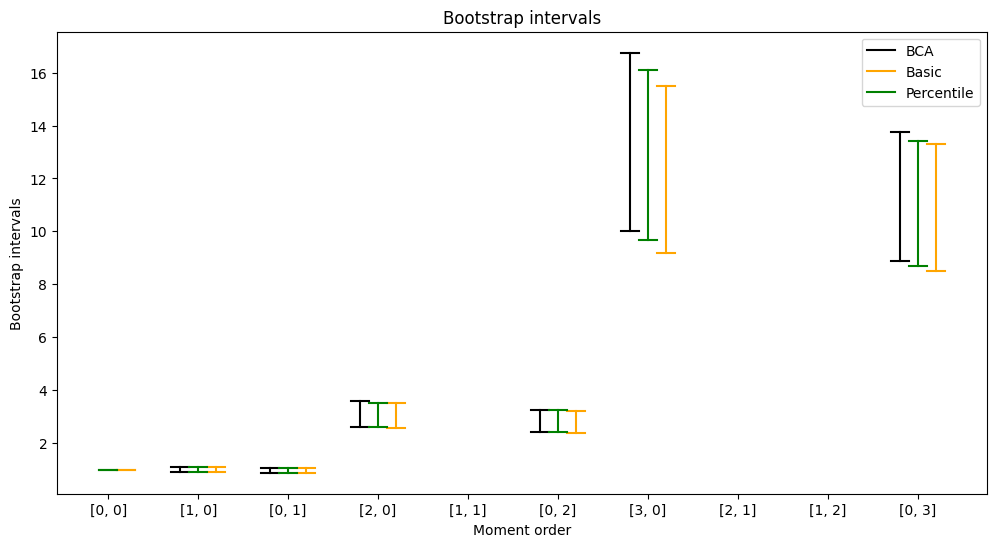

In [258]:
fig, axs = plt.subplots(figsize=(12, 6))
Nd = compute_Nd(S=2, d=d_boot)
#estimates = (percentile_estimates - exact_moments) / exact_moments
#sns.violinplot(estimates, inner=None, palette=["lightblue"] * Nd)
eps = 0.1
dt = 0.2
label_BC = "BCA"
label_B="Basic"
label_P="Percentile"
for i in range(Nd):
    if i > 0:
        label_BC = None
        label_B = None
        label_P = None
    # BCA
    lb = intervals_bca[0, i]
    ub = intervals_bca[1, i]
    plt.plot([i - eps - dt, i + eps - dt], [lb, lb], color="black", label=label_BC)
    plt.plot([i - eps - dt, i + eps - dt], [ub, ub], color="black")
    plt.plot([i - dt, i - dt], [lb, ub], color="black")
    # Basic
    lb = intervals_basic[0, i]
    ub = intervals_basic[1, i]
    plt.plot([i - eps + dt, i + eps + dt], [lb, lb], color="orange", label=label_B)
    plt.plot([i - eps + dt, i + eps + dt], [ub, ub], color="orange")
    plt.plot([i + dt, i + dt], [lb, ub], color="orange")
    # Percentile
    lb = intervals_percentile[0, i]
    ub = intervals_percentile[1, i]
    plt.plot([i - eps, i + eps], [lb, lb], color="green", label=label_P)
    plt.plot([i - eps, i + eps], [ub, ub], color="green")
    plt.plot([i, i], [lb, ub], color="green")
axs.set_xticks(range(Nd))
axs.set_xticklabels(compute_powers(S=2, d=d_boot))
plt.xlabel("Moment order")
plt.ylabel("Bootstrap intervals")
plt.title("Bootstrap intervals")
plt.legend()
plt.show()

## Real data

In [265]:
import pandas as pd
import json

In [ ]:
# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# remove outlier
data_counts = data_FIB.drop(labels=['Fibroblasts_P23_S383'], axis=1)

# read RNA types in from file
biotypes_dict = json.load(open("../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# select indices of protein coding (~mRNA) and non-coding miRNA
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# separate data
data_counts_pcRNA = data_counts.iloc[pcRNA_indices]
data_counts_miRNA = data_counts.iloc[miRNA_indices]

In [269]:
# select
miRNA = "MIR100"
mRNA_idx = 0

# construct sample
sample_miRNA = data_counts_miRNA.loc[miRNA]
sample_mRNA = data_counts_pcRNA.iloc[mRNA_idx]
sample = list(zip(sample_miRNA, sample_mRNA))

In [277]:
# choose order
d_boot = 2

# run bootstraps
intervals_bca = scipy_intervals(sample, d_boot, "bca")
intervals_basic = scipy_intervals(sample, d_boot, "basic")
intervals_percentile = scipy_intervals(sample, d_boot, "percentile")

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\willi\AppData\Local\Temp\ipykernel_22556\2432251564.py:11: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  boot = scipy.stats.bootstrap(np.array([x[1] for x in sample]).reshape(1, -1), statistic, method=btype)


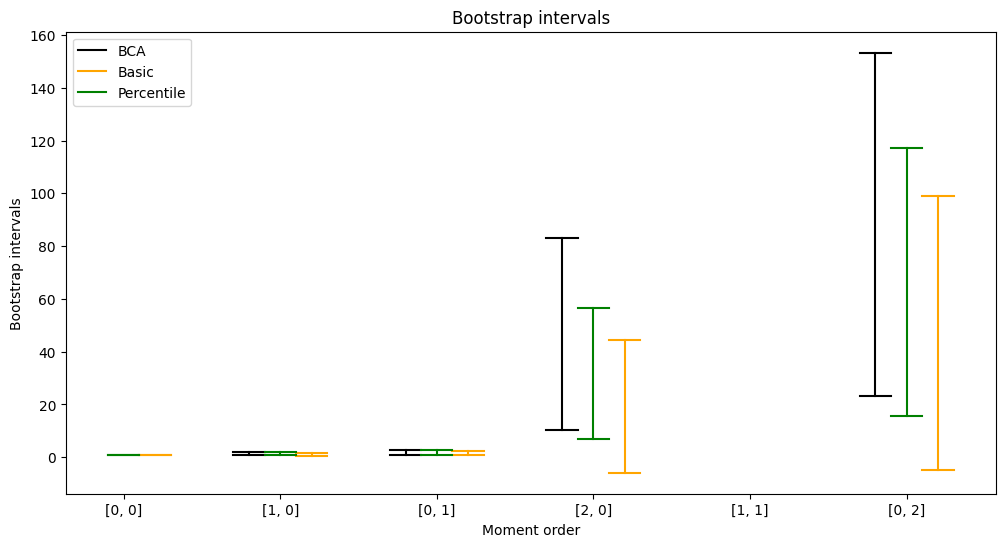

In [278]:
fig, axs = plt.subplots(figsize=(12, 6))
Nd = compute_Nd(S=2, d=d_boot)
#estimates = (percentile_estimates - exact_moments) / exact_moments
#sns.violinplot(estimates, inner=None, palette=["lightblue"] * Nd)
eps = 0.1
dt = 0.2
label_BC = "BCA"
label_B="Basic"
label_P="Percentile"
for i in range(Nd):
    if i > 0:
        label_BC = None
        label_B = None
        label_P = None
    # BCA
    lb = intervals_bca[0, i]
    ub = intervals_bca[1, i]
    plt.plot([i - eps - dt, i + eps - dt], [lb, lb], color="black", label=label_BC)
    plt.plot([i - eps - dt, i + eps - dt], [ub, ub], color="black")
    plt.plot([i - dt, i - dt], [lb, ub], color="black")
    # Basic
    lb = intervals_basic[0, i]
    ub = intervals_basic[1, i]
    plt.plot([i - eps + dt, i + eps + dt], [lb, lb], color="orange", label=label_B)
    plt.plot([i - eps + dt, i + eps + dt], [ub, ub], color="orange")
    plt.plot([i + dt, i + dt], [lb, ub], color="orange")
    # Percentile
    lb = intervals_percentile[0, i]
    ub = intervals_percentile[1, i]
    plt.plot([i - eps, i + eps], [lb, lb], color="green", label=label_P)
    plt.plot([i - eps, i + eps], [ub, ub], color="green")
    plt.plot([i, i], [lb, ub], color="green")
axs.set_xticks(range(Nd))
axs.set_xticklabels(compute_powers(S=2, d=d_boot))
plt.xlabel("Moment order")
plt.ylabel("Bootstrap intervals")
plt.title("Bootstrap intervals")
plt.legend()
plt.show()

In [279]:
# choose order
d_boot = 3

# run bootstraps
intervals_bca = scipy_intervals(sample, d_boot, "bca")
intervals_basic = scipy_intervals(sample, d_boot, "basic")
intervals_percentile = scipy_intervals(sample, d_boot, "percentile")

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\willi\AppData\Local\Temp\ipykernel_22556\2432251564.py:11: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  boot = scipy.stats.bootstrap(np.array([x[1] for x in sample]).reshape(1, -1), statistic, method=btype)


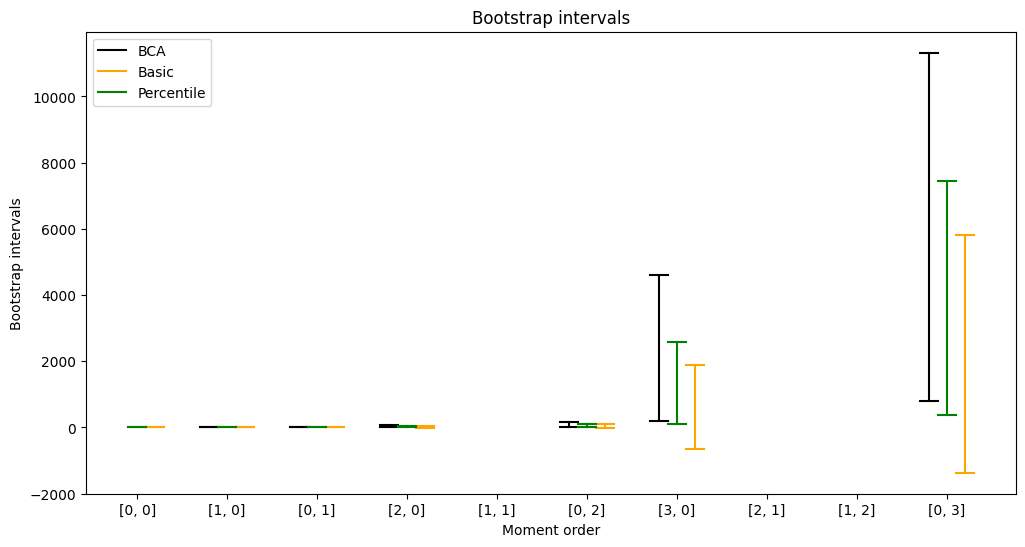

In [280]:
fig, axs = plt.subplots(figsize=(12, 6))
Nd = compute_Nd(S=2, d=d_boot)
#estimates = (percentile_estimates - exact_moments) / exact_moments
#sns.violinplot(estimates, inner=None, palette=["lightblue"] * Nd)
eps = 0.1
dt = 0.2
label_BC = "BCA"
label_B="Basic"
label_P="Percentile"
for i in range(Nd):
    if i > 0:
        label_BC = None
        label_B = None
        label_P = None
    # BCA
    lb = intervals_bca[0, i]
    ub = intervals_bca[1, i]
    plt.plot([i - eps - dt, i + eps - dt], [lb, lb], color="black", label=label_BC)
    plt.plot([i - eps - dt, i + eps - dt], [ub, ub], color="black")
    plt.plot([i - dt, i - dt], [lb, ub], color="black")
    # Basic
    lb = intervals_basic[0, i]
    ub = intervals_basic[1, i]
    plt.plot([i - eps + dt, i + eps + dt], [lb, lb], color="orange", label=label_B)
    plt.plot([i - eps + dt, i + eps + dt], [ub, ub], color="orange")
    plt.plot([i + dt, i + dt], [lb, ub], color="orange")
    # Percentile
    lb = intervals_percentile[0, i]
    ub = intervals_percentile[1, i]
    plt.plot([i - eps, i + eps], [lb, lb], color="green", label=label_P)
    plt.plot([i - eps, i + eps], [ub, ub], color="green")
    plt.plot([i, i], [lb, ub], color="green")
axs.set_xticks(range(Nd))
axs.set_xticklabels(compute_powers(S=2, d=d_boot))
plt.xlabel("Moment order")
plt.ylabel("Bootstrap intervals")
plt.title("Bootstrap intervals")
plt.legend()
plt.show()